# SARIMA
Seasonal ARIMA. Denoted by SARIMA(p, d, q)(P, D, Q)m.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Exploring the dataset

In [2]:
df = pd.read_csv('Datasets/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


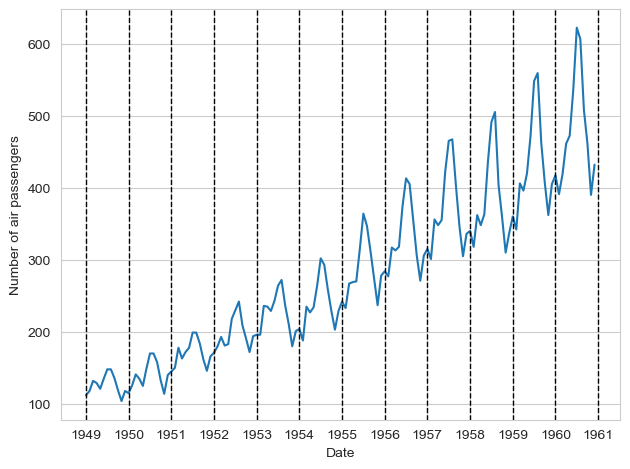

In [7]:
plt.plot(df['Month'], df['Passengers'])
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
for i in np.arange(0, 145, 12):
    plt.axvline(x=i, linestyle='--', color='black', linewidth=1)
plt.tight_layout()

* As we can seem there is a seasonal pattern observed for every year.
* There seems to be a peak in air passengers in the middle of each year.
* Another way of finding seasonality is by time series decomposition.
* Time series decomposition splits the time series data into 3 components, the trend component, the seasonal component and the residuals.

### Time series decomposition

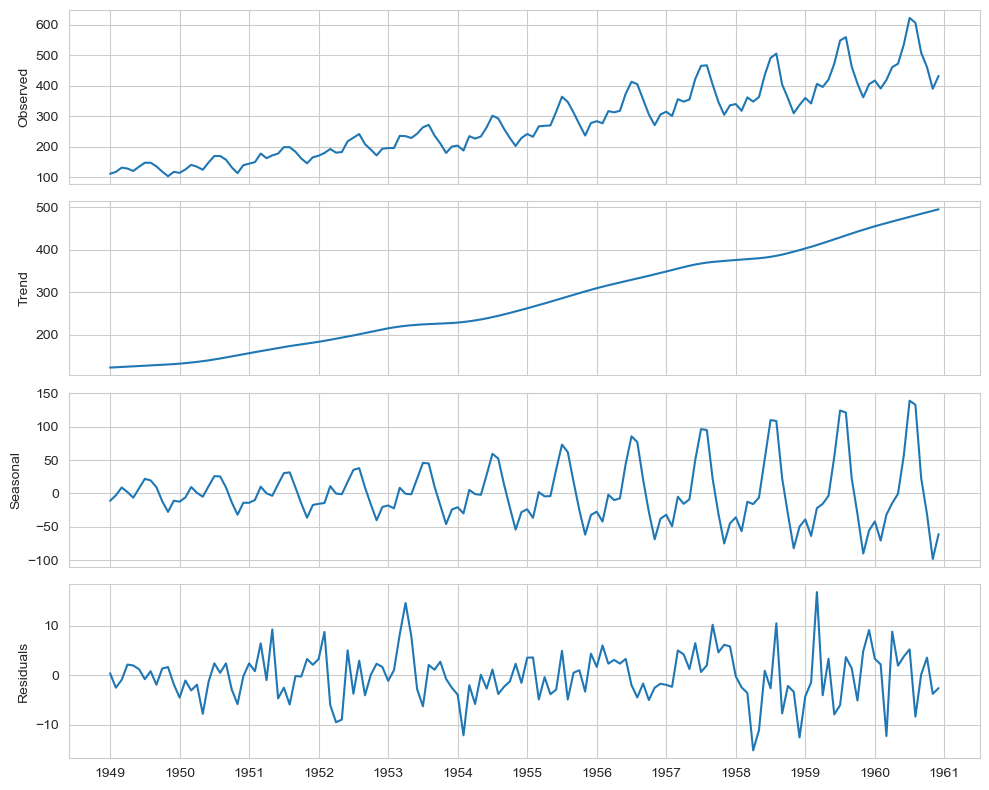

In [8]:
from statsmodels.tsa.seasonal import STL
decomposition = STL(df['Passengers'], period=12).fit()

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

ax[0].plot(decomposition.observed)
ax[0].set_ylabel('Observed')

ax[1].plot(decomposition.trend)
ax[1].set_ylabel('Trend')

ax[2].plot(decomposition.seasonal)
ax[2].set_ylabel('Seasonal')

ax[3].plot(decomposition.resid)
ax[3].set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
plt.tight_layout()

* So we can see that there is a clear seasonal component.
* And as the data is input monthly, we can set m=12.

## Determining the seasonal parameters

* We know that to determine 'd' we need to apply differencing until the data is stationary.
* To find the value of 'D' we apply seasonal differencing unti the same.

In [9]:
from statsmodels.tsa.stattools import adfuller
ADF = adfuller(df['Passengers'])
print("ADF Statistic = {}".format(ADF[0]))
print("p-value = {}".format(ADF[1]))

ADF Statistic = 0.8153688792060502
p-value = 0.991880243437641


* As we can see, the data is not stationary.

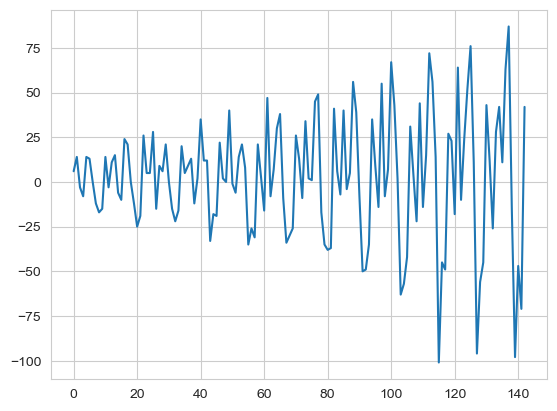

In [10]:
diff1 = np.diff(df.Passengers, n=1)
plt.plot(diff1)

In [11]:
ADF_diff1 = adfuller(diff1)
print("ADF Statistic = {}".format(ADF_diff1[0]))
print("p-value = {}".format(ADF_diff1[1]))

ADF Statistic = -2.829266824170006
p-value = 0.05421329028382468


* First differencing fails the stationarity test.
* So now we go for seasonal differencing.

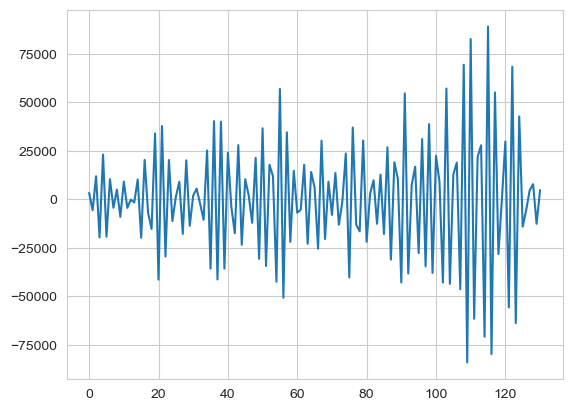

In [52]:
diff_seasonal = np.diff(diff1, n=12)
plt.plot(diff_seasonal)

In [53]:
ADF_diff_seasonal_12 = adfuller(diff_seasonal)
print("ADF Statistic = {}".format(ADF_diff_seasonal_12[0]))
print("p-value = {}".format(ADF_diff_seasonal_12[1]))

ADF Statistic = -17.624862360028917
p-value = 3.823046856539482e-30


* Here we can see that we pass the test after the first seasonal differencing.
* So, we can set D=1 and d=1.

## Splitting the data

In [16]:
train = df.iloc[:-12]
test = df.iloc[-12:]

In [17]:
train.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [24]:
train_data = train.Passengers
train_data[:20]

0     112
1     118
2     132
3     129
4     121
5     135
6     148
7     148
8     136
9     119
10    104
11    118
12    115
13    126
14    141
15    135
16    125
17    149
18    170
19    170
Name: Passengers, dtype: int64

In [18]:
test

,Month,Passengers
132,1960-01,417
133,1960-02,391
134,1960-03,419
135,1960-04,461
136,1960-05,472
137,1960-06,535
138,1960-07,622
139,1960-08,606
140,1960-09,508
141,1960-10,461


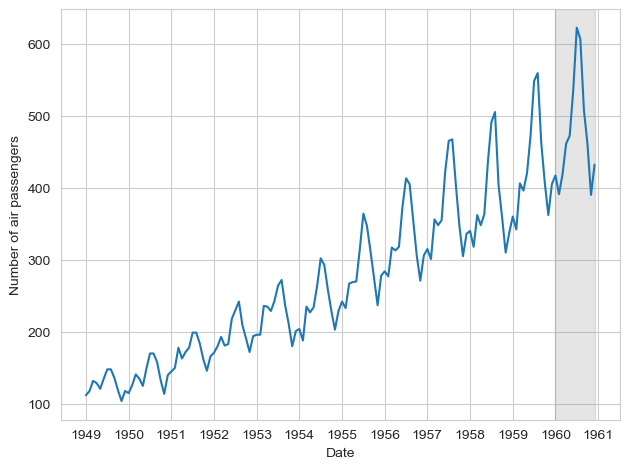

In [19]:
plt.plot(df['Month'], df['Passengers'])
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
plt.axvspan(132, 143, color="#808080", alpha=0.2)
plt.tight_layout()

## Selecting the SARIMA model

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(parameter_list, data, d, D, m) -> pd.DataFrame:
    """This function gets the list of all p, q, P, Q values and the d, D values, creates the model for each of the (p, d, q)(P, D, Q) values and then finds the AIC value of each of the model and 
    displays the output as a dataframe in ascending order of AIC values"""
    result = []
    for p, q, sP, sQ in parameter_list:
        model = SARIMAX(data, order=(p, d, q), seasonal_order=(sP, D, sQ, m), simple_differencing=False).fit(disp=False)
        aic = model.aic
        result.append([(p, q, sP, sQ), aic])
    result_df = pd.DataFrame(result)
    result_df.columns = ['(p, q, P, Q)', 'AIC']
    # Sorting in ascending order
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

* Generating all combinations of the parameters.

In [54]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_ordered_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
m = 12

SARIMA_ordered_list[:10]

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1)]

In [ ]:
result_df = optimize_SARIMA(SARIMA_ordered_list, train_data, d, D, m)
result_df

* Now the above takes to long to compute as it has to generate 256 different models, each with 7 parameters!!!
* But the ouput we get is as follows,
<br><br>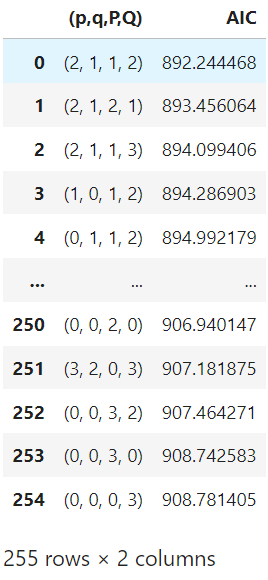

* So the best model is SARIMA(2, 1, 1)(1, 1, 2, 12).

In [55]:
model = SARIMAX(train_data, order=(2, 1, 1), seasonal_order=(1, 1, 2, 12), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.125
Date:                                 Mon, 27 Mar 2023   AIC                            892.250
Time:                                         23:48:26   BIC                            911.704
Sample:                                              0   HQIC                           900.150
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2665      0.085    -14.971      0.000      -1.432      -1

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Residual Analysis 

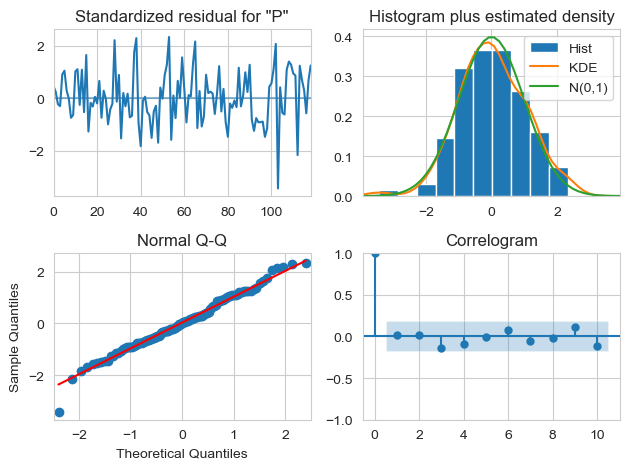

In [56]:
model_fit.plot_diagnostics()
plt.tight_layout()

* All the plots satisfy our requirements.

In [57]:
residuals = model_fit.resid

In [58]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung = acorr_ljungbox(residuals, np.arange(1, 11, 1)) # the arrange specifies the lags upto which we are testing, here we are testing the first 10 lags
ljung['lb_pvalue']

1     0.945490
2     0.688529
3     0.795776
4     0.873665
5     0.920252
6     0.944134
7     0.940805
8     0.950788
9     0.973907
10    0.893228
Name: lb_pvalue, dtype: float64

* The residuals are also uncorrelated.

## Predicting the values

In [59]:
test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
test

C:\Users\delli\AppData\Local\Temp\ipykernel_16124\200521962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = df['Passengers'].iloc[120:132].values


,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


In [60]:
model_pred = model_fit.get_prediction(132, 143).predicted_mean

In [62]:
test['SARIMA_pred'] = model_pred
test

C:\Users\delli\AppData\Local\Temp\ipykernel_16124\3825046524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = model_pred


,Month,Passengers,naive_seasonal,SARIMA_pred
132,1960-01,417,360,418.519734
133,1960-02,391,342,399.579598
134,1960-03,419,406,461.315912
135,1960-04,461,396,451.440056
136,1960-05,472,420,473.751938
137,1960-06,535,472,538.788868
138,1960-07,622,548,612.478788
139,1960-08,606,559,624.666265
140,1960-09,508,463,520.185488
141,1960-10,461,407,462.855092


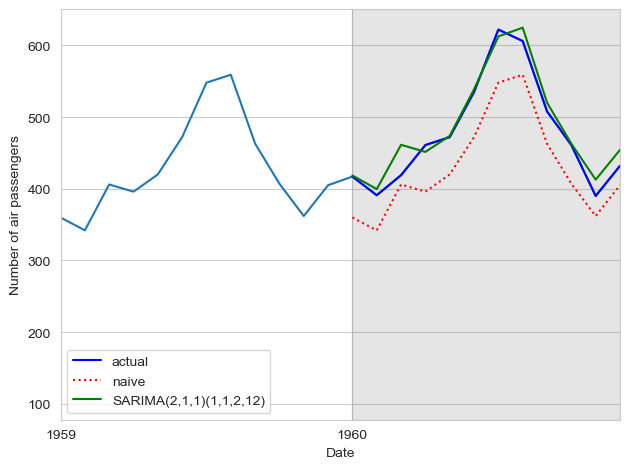

In [63]:
plt.plot(df['Month'], df['Passengers'])
plt.plot(test['Passengers'], 'b-', label='actual')
plt.plot(test['naive_seasonal'], 'r:', label='naive')
plt.plot(test['SARIMA_pred'], 'g-', label='SARIMA(2,1,1)(1,1,2,12)')
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.axvspan(132, 143, color='#808080', alpha=0.2)
plt.legend()
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
plt.xlim(120, 143)
plt.tight_layout()

## Quantifying the error

In [64]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [65]:
mape_naive = mape(test['Passengers'], test['naive_seasonal']) 
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

Text(0, 0.5, 'MAPE (%)')

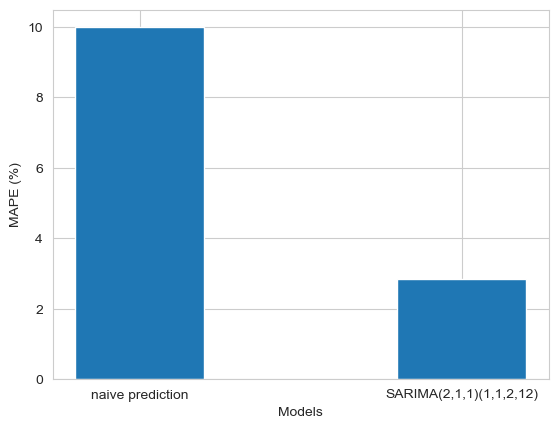

In [66]:
plt.bar(['naive prediction', 'SARIMA(2,1,1)(1,1,2,12)'], [mape_naive, mape_SARIMA], width=0.4)
plt.xlabel('Models')
plt.ylabel('MAPE (%)')

* If we fit an ARIMA model for the same data, we observe that the SARIMA model will be better than it.